In [1]:
import numpy as np

import matplotlib.pyplot as plt

from LIMxCMBL.cross_spectrum import *
from LIMxCMBL.init import *
from LIMxCMBL.noise import *
from LIMxCMBL.kernels import *

from scipy.signal.windows import dpss

from tqdm import tqdm

# CCAT-prime
zmin = 3.5
zmax = 8.1
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
window = np.where((chis_resample > chimin) & (chis_resample < chimax))[0]

_chimin, _chimax = chis_resample[window][0], chis_resample[window][-1]


Lambdas = np.logspace(-5, 0, 50)
Lambda = Lambdas[21]
print(Lambda)



chis_resample_len = int(np.log2(len(chis_resample)))
print(chis_resample_len)
oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, Lambda,chis_resample_len)
eIeI = np.load(oup_fname + 'eIeI.npy')
eIeLO = np.load(oup_fname + 'eIeLO.npy' ,)
eLOeI = np.load(oup_fname + 'eLOeI.npy' , )
eLOeLO = np.load(oup_fname + 'eLOeLO.npy', )
eHIeHI = eIeI + eLOeLO - eIeLO - eLOeI

IHi_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, Lambda,chis_resample_len)
IHi_kappa = np.load(IHi_kappa_fname) #[kJy/sr Mpc]
IHi_kappa_windowed = IHi_kappa[:, window].astype(np.float64)

0.0013894954943731374
10


In [2]:
chis_restricted = chis_resample[np.where((chis_resample >= chimin) & (chis_resample <= chimax))]

In [3]:
D = np.diag(chis_restricted)

d = D @ IHi_kappa_windowed.T
L = np.linalg.cholesky(D @ eHIeHI @ D)
y = np.linalg.solve(L, d)
x = np.linalg.solve(L.T, y)
res1 = np.einsum('ij, ji->i', d.T, x)

In [4]:
mpm_chis = mpm.linspace(np.min(chis_restricted), np.max(chis_restricted), len(chis_restricted))

In [5]:
mpm_dchi = mpm_chis[1] - mpm_chis[0]

In [6]:
results = f_eHIeHI(chimin = chimin, 
                   chimax = chimax, 
                   dchi = mpm_dchi, 
                   chis = mpm_chis, 
                   Lambda = Lambda)

import pickle
oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, Lambda,chis_resample_len)
with open(oup_fname, 'wb') as f:
    print(oup_fname)
    pickle.dump(results, f)

Computing matrix elements: 100%|██████████| 21321/21321 [00:04<00:00, 4531.72it/s]


/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_zmin_3.50000_zmax_8.10000_Lambda_1.38950e-03_chi_sample_2e10


In [7]:
# import pickle
# oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, Lambda,chis_resample_len)
# with open(oup_fname, 'rb') as f:
#     results = pickle.load(f)

In [8]:
mpm_eIeI = np.zeros_like(eHIeHI, dtype = np.complex128)
mpm_eLOeLO = np.zeros_like(eHIeHI, dtype = np.complex128)
mpm_cross = np.zeros_like(eHIeHI, dtype = np.complex128)

for i, j, _eIeI, _cross, _eLOeLO in tqdm(results):
    mpm_eIeI[i,j] = _eIeI
    mpm_eLOeLO[i,j] = mpm_eLOeLO[j,i] = _eLOeLO
    mpm_cross[i,j] = mpm_cross[j,i] = _cross

100%|██████████| 21321/21321 [00:00<00:00, 116121.60it/s]


In [9]:
mpm_eHIeHI = mpm_eIeI + mpm_eLOeLO - mpm_cross
mpm_eHIeHI = np.real(mpm_eHIeHI)

In [10]:
D = np.diag(chis_restricted)
d = D @ IHi_kappa_windowed.T
L = np.linalg.cholesky(D @ mpm_eHIeHI @ D)
y = np.linalg.solve(L, d)
x = np.linalg.solve(L.T, y)
res2 = np.einsum('ij, ji->i', d.T, x)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


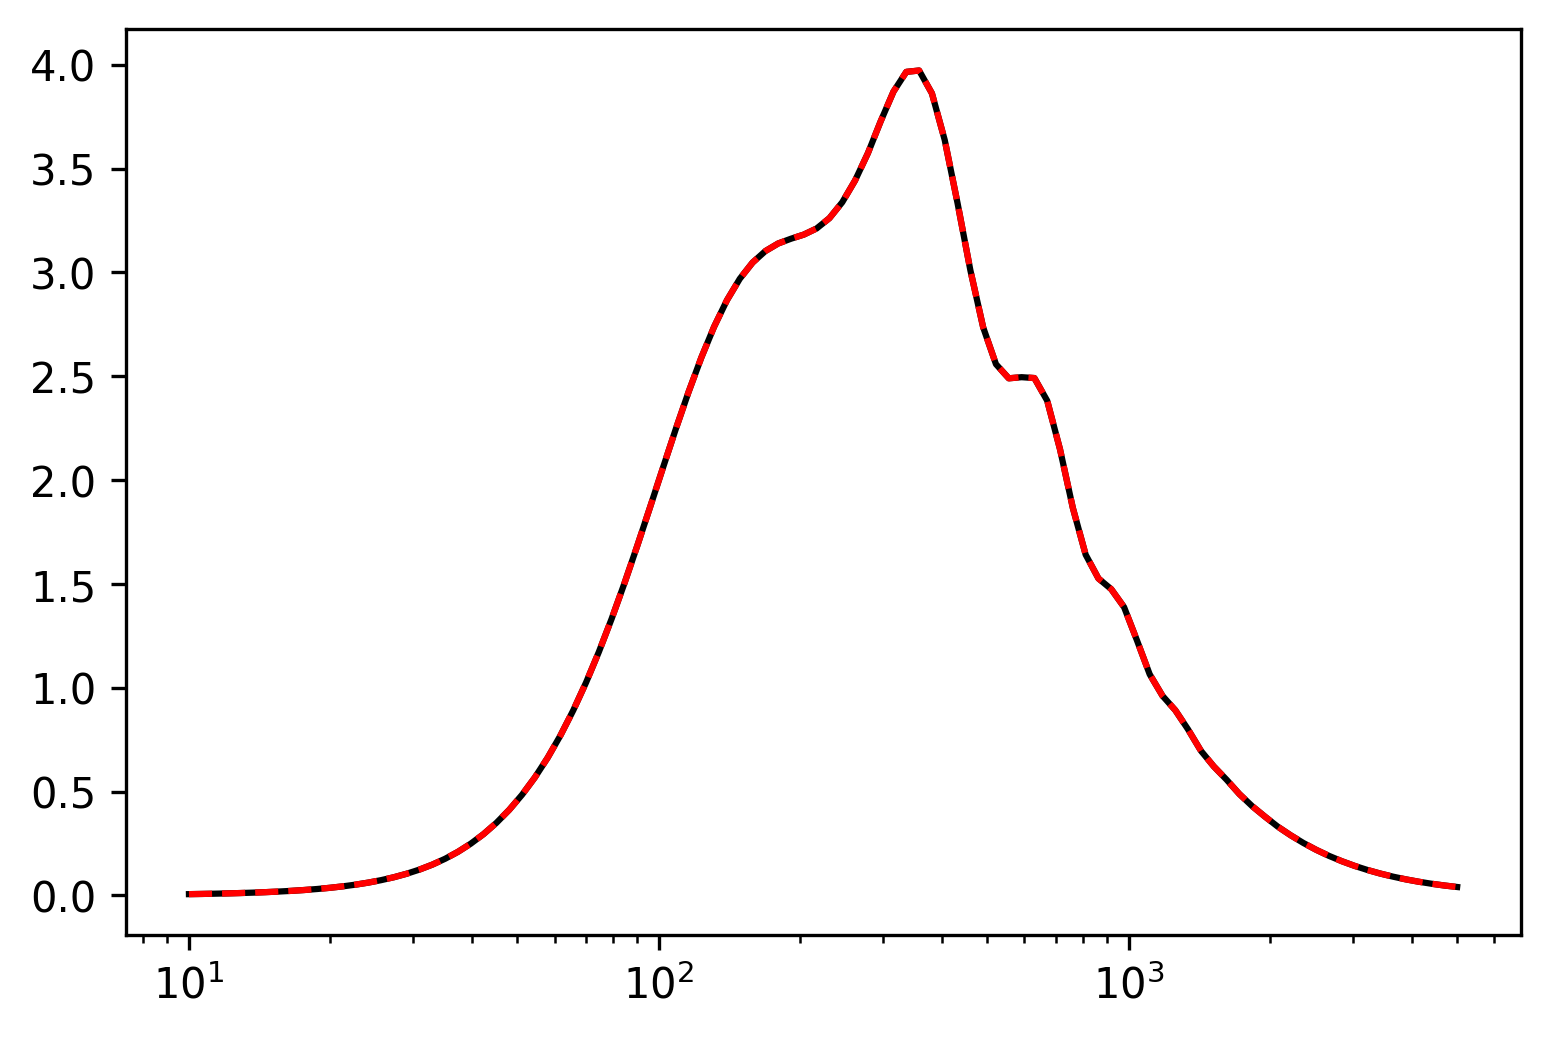

In [11]:
plt.figure(dpi = 300)
plt.plot(ells, ells**2 * res1, 'k')
plt.plot(ells, ells**2 * res2, 'r--')

plt.legend(frameon=False)
plt.xscale('log')

In [12]:
# y = np.linalg.solve(L, d)
# x = np.linalg.solve(L.T, y)
# res1 = np.einsum('ij, ji->i', d.T, x)

In [13]:
mpm_eHIeHI_not_numpy = mpm.zeros(len(window))

for i, j, _eIeI, _cross, _eLOeLO in tqdm(results):
    mpm_eHIeHI_not_numpy[i,j] = mpm.re(_eIeI + _eLOeLO - _cross)
    mpm_eHIeHI_not_numpy[j,i] = mpm_eHIeHI_not_numpy[i,j]

100%|██████████| 21321/21321 [00:00<00:00, 119551.61it/s]


In [14]:
len(mpm_eHIeHI_not_numpy)

206

In [15]:
len(d)

206

In [20]:
res4 = [0] * len(ells)

for ell_idx in trange(len(ells)):
    d = mpm.matrix(IHi_kappa_windowed[ell_idx])
    x = mpm.cholesky_solve(mpm_eHIeHI_not_numpy, d)
    res4[ell_idx] = mpm.fdot(d, x)

100%|██████████| 100/100 [06:07<00:00,  3.68s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


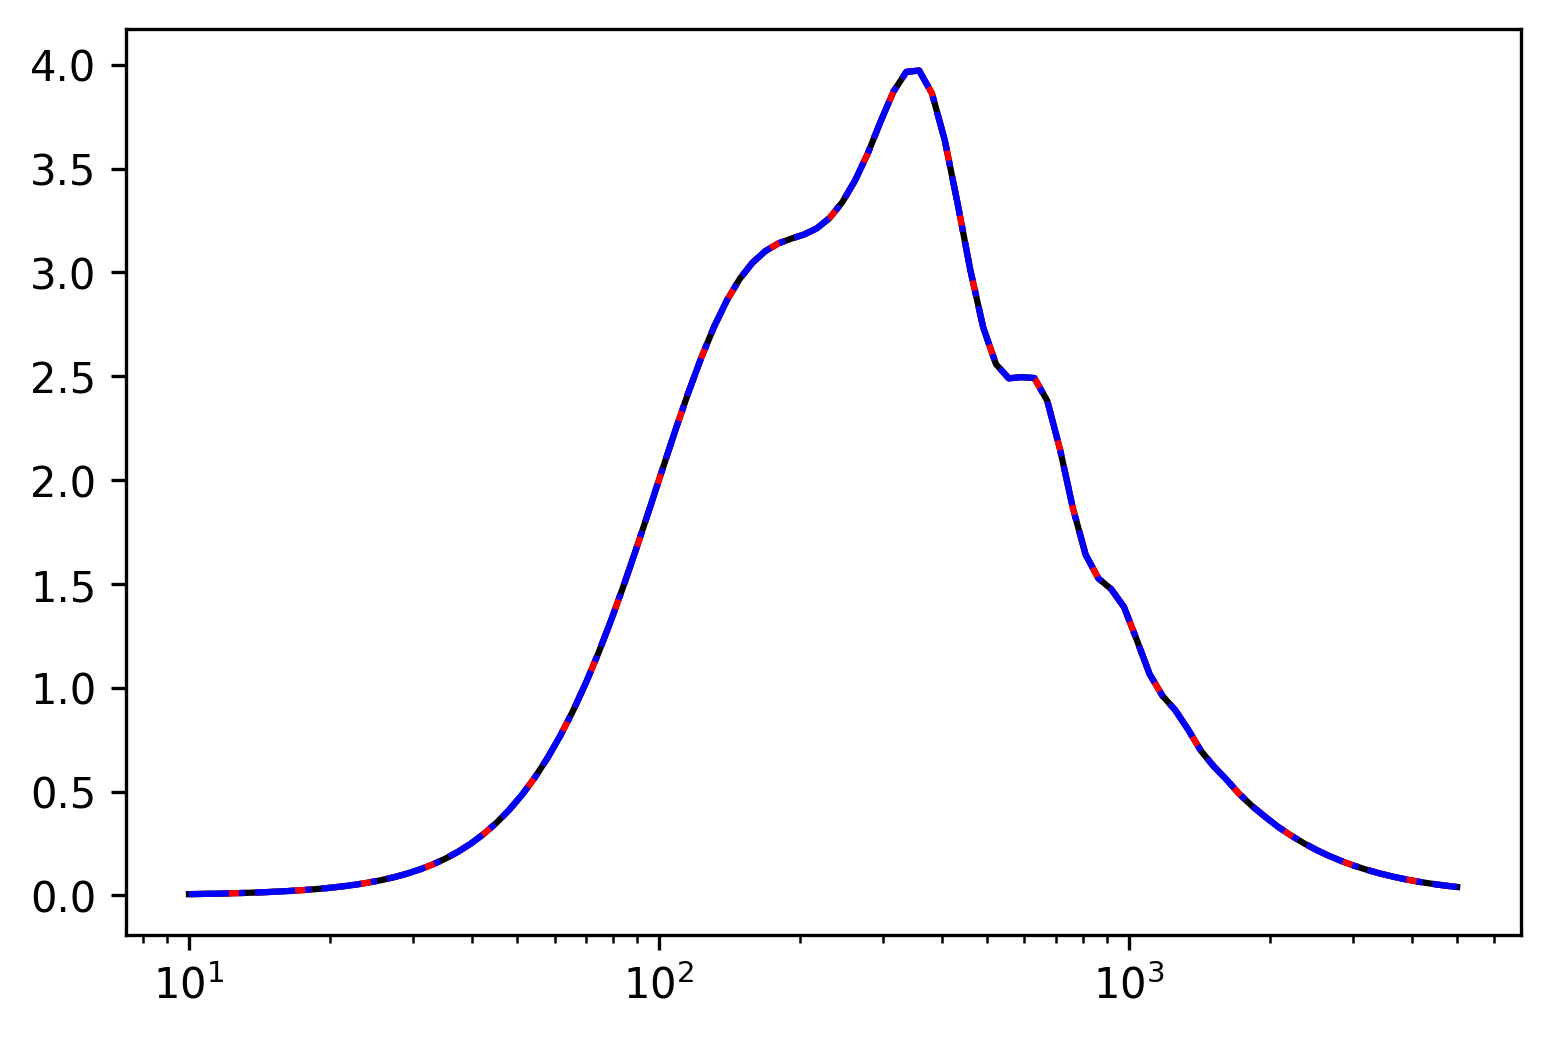

In [21]:
plt.figure(dpi = 300)
plt.plot(ells, ells**2 * res1, 'k')
plt.plot(ells, ells**2 * res2, 'r--')
plt.plot(ells, ells**2 * res4, 'b-.')

plt.legend(frameon=False)
plt.xscale('log')

In [ ]:
# mpm_chis_dense = mpm.linspace(np.min(chis_restricted), 
#                               np.max(chis_restricted), 
#                               3 * len(chis_restricted))
# mpm_dchi = mpm_chis_dense[1] - mpm_chis_dense[0]

# results = f_eHIeHI(chimin = chimin, 
#                    chimax = chimax, 
#                    dchi = mpm_dchi, 
#                    chis = mpm_chis_dense, 
#                    Lambda = Lambda)


# import pickle
# oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_zmin_tmp_testing'
# with open(oup_fname, 'wb') as f:
#     print(oup_fname)
#     pickle.dump(results, f)

In [ ]:
# mpm_eIeI = np.zeros((len(mpm_chis_dense), len(mpm_chis_dense)), dtype = np.complex128)
# mpm_eLOeLO = np.zeros((len(mpm_chis_dense), len(mpm_chis_dense)), dtype = np.complex128)
# mpm_cross = np.zeros((len(mpm_chis_dense), len(mpm_chis_dense)), dtype = np.complex128)

# for i, j, _eIeI, _cross, _eLOeLO in tqdm(results):
#     mpm_eIeI[i,j] = _eIeI
#     mpm_eLOeLO[i,j] = mpm_eLOeLO[j,i] = _eLOeLO
#     mpm_cross[i,j] = mpm_cross[j,i] = _cross

In [ ]:
# mpm_eHIeHI = mpm_eIeI + mpm_eLOeLO - mpm_cross
# mpm_eHIeHI = np.real(mpm_eHIeHI)

In [ ]:
# chis_dense = np.linspace(np.min(chis_restricted), 
#                               np.max(chis_restricted), 
#                               3 * len(chis_restricted))

In [ ]:
# D = np.diag(chis_dense)
# d_dense = f_d(chis_dense)
# L = np.linalg.cholesky(D @ mpm_eHIeHI @ D)

In [ ]:
# y = np.linalg.solve(L, d_dense)
# x = np.linalg.solve(L.T, y)
# res3 = np.einsum('ij, ji->i', d_dense.T, x)

In [ ]:
# plt.figure(dpi = 300)
# plt.plot(ells, ells**2 * res1, 'k')
# plt.plot(ells, ells**2 * res2, 'r--')
# plt.plot(ells, ells**2 * res3, 'b-.')

# plt.legend(frameon=False)
# plt.xscale('log')